In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from models.EvenSmallerCNN import EvenSmallerCNN
from models.Inception import Inception
from models.ShuffleNet2 import ShuffleNet2
from models.SmallInception import SmallInception
from models.SmallerCNN import SmallerCNN
from models.SteeringCNN import SteeringCNN
from models.VGG16BasedNet import VGG16BasedNet
from models.MobileNetSmall import MobileNetSmall
from utils import train_model, get_model_size

In [48]:
if torch.cuda.is_available():
    print("Using cuda")
    torch.set_default_device('cuda:0')

Using cuda


In [49]:
# dataset_folder = os.path.join("put_jetbot_dataset", "dataset")
dataset_folder = "dataset"
exports_folder = "models_snapshots"
print(os.listdir(dataset_folder))

['376_1', '376_1.csv', '456_1', '456_1.csv', '456_2', '456_2.csv', '493_1', '493_1.csv', '493_2', '493_2.csv', '493_3', '493_3.csv', 'good_turns', 'good_turns.csv', 'good_turns_bog', 'good_turns_bog.csv', 'long', 'long.csv', 'long_turns', 'long_turns.csv', 'nice_race', 'nice_race.csv', 'our_fast', 'our_fast.csv', 'our_fast_short', 'our_fast_short.csv', 'our_good_driving', 'our_good_driving.csv', 'the-cones', 'the-cones.csv', 'the-red-kettle', 'the-red-kettle.csv', 'the-short', 'the-short.csv', 'the-speedy-cones', 'the-speedy-cones.csv', 'turn_left', 'turn_left.csv', 'zip_skipper', 'zip_skipper.csv']


In [50]:
X = []
y = []

for file in os.listdir(dataset_folder):
    if not file.endswith(".csv"):
        continue

    dataset_name = file[:-4]

    data = pd.read_csv(os.path.join(dataset_folder, str(file)), header=None)

    for _, row in data.iterrows():
        img_id, forward, left = row
        img_path = os.path.join(dataset_folder, dataset_name, f"{int(img_id):04d}.jpg")
        if not os.path.exists(img_path) or forward < 0:
            continue

        X.append(img_path)
        y.append([forward, left])
        

X = np.array(X)

y = np.array(y, dtype=np.float32)

X.shape, y.shape

((8734,), (8734, 2))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.25)

In [52]:
class JetBotImageDataset(Dataset):
    def __init__(self, image_paths, image_ys, transform=None):
        self.image_paths = image_paths
        self.image_ys = image_ys
        self.transform = transform

        assert len(image_paths) == len(image_ys)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        label = self.image_ys[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [53]:
transform = v2.Compose([
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    v2.GaussianBlur(7, (0.01, 2.0)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [54]:
train_dataset = JetBotImageDataset(X_train, y_train, transform)
test_dataset = JetBotImageDataset(X_test, y_test, transform)

In [55]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [56]:
train_features, train_labels = next(iter(test_dataloader))

In [57]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


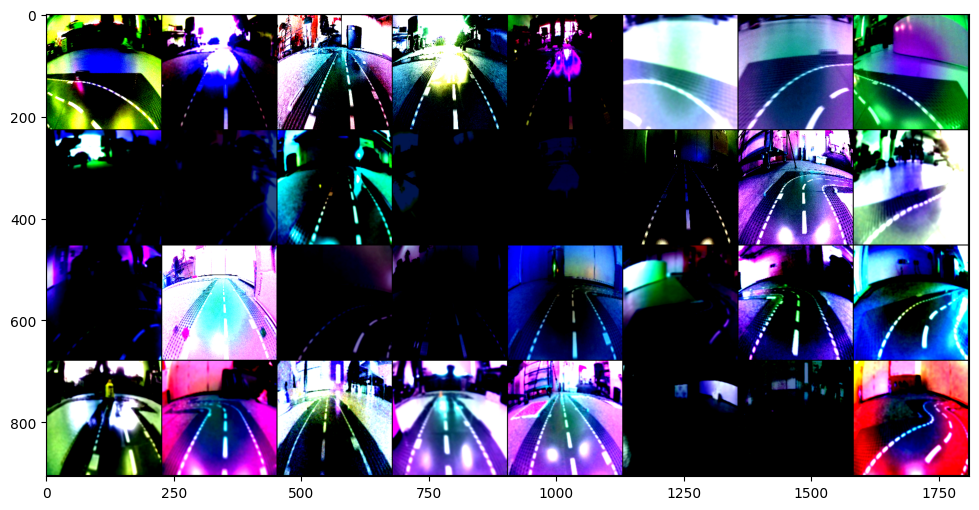

In [58]:
imshow(torchvision.utils.make_grid(train_features))

In [59]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


# SteeringCNN

In [46]:
net = SteeringCNN()
net.to(device)

SteeringCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (forward_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (left_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [48]:
train_model(net, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.23644637569785118
  batch 100 loss: 0.2184069512784481
  batch 150 loss: 0.2247887869179249
  batch 200 loss: 0.22130802989006043
  batch 250 loss: 0.22855102255940438
  batch 300 loss: 0.21838809356093405
  batch 350 loss: 0.23278301268815993
LOSS train 0.23278301268815993 valid 0.19567836821079254 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.2097634707391262
  batch 100 loss: 0.18680019184947014
  batch 150 loss: 0.1873336075246334
  batch 200 loss: 0.18128768384456634
  batch 250 loss: 0.17864453420042992
  batch 300 loss: 0.17051764488220214


KeyboardInterrupt: 

In [22]:
get_model_size(net)

1606170

In [24]:
import torch.onnx

x = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)

torch.onnx.export(net, x, os.path.join(exports_folder, 'SteeringCNN.onnx'), export_params=True, opset_version=11)

In [25]:
del net

# Smaller model proposition

In [19]:
sm_net = SmallerCNN()
sm_net.to(device)

SmallerCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=12544, out_feature

In [20]:
get_model_size(sm_net)

1195618

In [21]:
train_model(sm_net, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.2567049364745617
  batch 100 loss: 0.22218371778726578
  batch 150 loss: 0.22831970646977426
  batch 200 loss: 0.239301655292511
  batch 250 loss: 0.24647481933236123
  batch 300 loss: 0.22626442551612855
  batch 350 loss: 0.2519469550251961
LOSS train 0.2519469550251961 valid 0.23177503049373627 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.23863450631499292
  batch 100 loss: 0.223060489743948
  batch 150 loss: 0.22618984147906304
  batch 200 loss: 0.2374797461926937
  batch 250 loss: 0.24380234137177467
  batch 300 loss: 0.22514143824577332
  batch 350 loss: 0.25135738879442215
LOSS train 0.25135738879442215 valid 0.23259294033050537 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.2382572530210018
  batch 100 loss: 0.22248838938772678
  batch 150 loss: 0.22625043258070945
  batch 200 loss: 0.2372253282368183
  batch 250 loss: 0.24316064149141312
  batch 300 loss: 0.22514186546206474
  batch 350 loss: 0.2514588671922684
LOSS train 0.2514588671922684 valid

In [22]:
# export as onnx with OPSET 11
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(sm_net, x, os.path.join(exports_folder, 'smaller_cnn_1p2m.onnx'), export_params=True, opset_version=11)

In [23]:
del sm_net

# Can we go even smaller?

In [24]:
model = EvenSmallerCNN()
get_model_size(model)

499922

In [25]:
train_model(model, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.2627822782099247
  batch 100 loss: 0.23047351144254208
  batch 150 loss: 0.23389074727892875
  batch 200 loss: 0.24681055143475533
  batch 250 loss: 0.25008968129754067
  batch 300 loss: 0.2326356403529644
  batch 350 loss: 0.2612695980072022
LOSS train 0.2612695980072022 valid 0.23417812585830688 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.24390205964446068
  batch 100 loss: 0.22851597815752028
  batch 150 loss: 0.23418329358100892
  batch 200 loss: 0.24640825659036636
  batch 250 loss: 0.2496636714041233
  batch 300 loss: 0.23225342303514482
  batch 350 loss: 0.2616165682673454
LOSS train 0.2616165682673454 valid 0.2340957671403885 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.24396467730402946
  batch 100 loss: 0.22835711434483527
  batch 150 loss: 0.234266886562109
  batch 200 loss: 0.24638571202754975
  batch 250 loss: 0.2496271938085556
  batch 300 loss: 0.2322157582640648
  batch 350 loss: 0.261663379073143
LOSS train 0.261663379073143 valid 0.2

In [26]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(model, x, os.path.join(exports_folder, 'even_smaller_cnn_0p5m.onnx'), export_params=True, opset_version=11)

In [27]:
del model

# ShuffleNet

In [60]:
shufflenet = ShuffleNet2(net_type=0.5)
shufflenet.to(device)

ShuffleNet2(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stages): Sequential(
    (0): ShuffleBlock(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (4): 

In [61]:
get_model_size(shufflenet)

407498

In [62]:
train_model(shufflenet, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.2550140109658241
  batch 100 loss: 0.2386627198755741
  batch 150 loss: 0.22647400319576264
  batch 200 loss: 0.19596220433712006
LOSS train 0.19596220433712006 valid 0.2162095606327057 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.15773791447281837
  batch 100 loss: 0.1412457764148712
  batch 150 loss: 0.13004798635840417
  batch 200 loss: 0.12900547325611114
LOSS train 0.12900547325611114 valid 0.12477735430002213 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.12316703408956528
  batch 100 loss: 0.11985718294978141
  batch 150 loss: 0.11454032137989997
  batch 200 loss: 0.11812030978500843
LOSS train 0.11812030978500843 valid 0.11156439781188965 learning rate 0.001
EPOCH 4:
  batch 50 loss: 0.11144542500376702
  batch 100 loss: 0.11123402267694474
  batch 150 loss: 0.1047252681851387
  batch 200 loss: 0.11171587765216827
LOSS train 0.11171587765216827 valid 0.10794560611248016 learning rate 0.001
EPOCH 5:
  batch 50 loss: 0.1098433455824852
  batch 100 

KeyboardInterrupt: 

In [63]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(shufflenet, x, os.path.join(exports_folder, 'shufflenet_adam.onnx'), export_params=True, opset_version=11)

In [64]:
del shufflenet

# Inception

In [26]:
inception_net = Inception(3)
get_model_size(inception_net)

2095034

In [27]:
train_model(inception_net, 100, train_dataloader, test_dataloader, device)

EPOCH 1:


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [35]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(inception_net, x, os.path.join(exports_folder, 'inception.onnx'), export_params=True, opset_version=11)

In [36]:
del inception_net

# SmallInception

In [119]:
small_inception_net = SmallInception(3)
small_inception_net.to(device)
get_model_size(small_inception_net)

672370

In [120]:
train_model(small_inception_net, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.20015896409749984
  batch 100 loss: 0.13337056145071982
  batch 150 loss: 0.12234866693615913
  batch 200 loss: 0.12201897606253624


c:\Users\mkami\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return func(*args, **kwargs)


LOSS train 0.12201897606253624 valid 0.12565918266773224 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.10880238339304923
  batch 100 loss: 0.10466907896101475
  batch 150 loss: 0.1045051220804453
  batch 200 loss: 0.10654080420732498
LOSS train 0.10654080420732498 valid 0.10060060024261475 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.09885314859449863
  batch 100 loss: 0.09789685346186161
  batch 150 loss: 0.09862537190318107
  batch 200 loss: 0.0982512429356575
LOSS train 0.0982512429356575 valid 0.10730849206447601 learning rate 0.001
EPOCH 4:
  batch 50 loss: 0.09212419614195824
  batch 100 loss: 0.09317814111709595
  batch 150 loss: 0.08993764080107212
  batch 200 loss: 0.09520717903971672
LOSS train 0.09520717903971672 valid 0.08932451158761978 learning rate 0.001
EPOCH 5:
  batch 50 loss: 0.08924838103353977
  batch 100 loss: 0.08751980394124985
  batch 150 loss: 0.08601118974387646
  batch 200 loss: 0.09043599724769592
LOSS train 0.09043599724769592 valid 0.0890479832887649

KeyboardInterrupt: 

In [121]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(small_inception_net, x, os.path.join(exports_folder, 'small_inception.onnx'), export_params=True, opset_version=11)

In [122]:
del small_inception_net

In [45]:
mobile = MobileNetSmall()
mobile.to(device)

MobileNetSmall(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Con

In [46]:
get_model_size(mobile)

1519906

In [47]:
train_model(mobile, 100, train_dataloader, test_dataloader, device, lr = 0.01)

EPOCH 1:
  batch 50 loss: 3.489811375141144
  batch 100 loss: 0.26389159172773363
LOSS train 0.26389159172773363 valid 0.23872335255146027 learning rate 0.01
EPOCH 2:
  batch 50 loss: 0.2513422495126724
  batch 100 loss: 0.23750345200300216
LOSS train 0.23750345200300216 valid 0.23458066582679749 learning rate 0.01
EPOCH 3:
  batch 50 loss: 0.2582061219215393
  batch 100 loss: 0.23531185299158097
LOSS train 0.23531185299158097 valid 0.23376362025737762 learning rate 0.01
EPOCH 4:
  batch 50 loss: 0.23481899946928025


KeyboardInterrupt: 

In [37]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(mobile, x, os.path.join(exports_folder, 'mobile_ogdata.onnx'), export_params=True, opset_version=11)

In [38]:
del mobile